### Final Project Code Base

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

from torchvision.datasets.utils import download_url, check_integrity

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import glob
import cv2
import torch
import torchvision.utils as vutils
import torchvision.models as models
import torch.optim as optim
import scipy.io
from torch.utils.data import Dataset
from torchvision import transforms

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


IS_GPU = True
TEST_BS = 2
TRAIN_BS = 4
dataroot='/content/drive/MyDrive/585_data/alt_images/'
# dataroot='/content/drive/MyDrive/585_data/'

train_transform = transforms.Compose(
    [
     transforms.CenterCrop((224,224)),
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
     transforms.ToTensor(),
    #  transforms.Normalize(mean=[0.46447453, 0.42939538, 0.39643392], std=[0.27552935, 0.26626697, 0.27488974])
     ])

test_transform = transforms.Compose(
    [
     transforms.CenterCrop((224,224)),
     transforms.ToTensor(),
    #  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
# ---------------------

import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class GANDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        
        self.img_folder = os.path.join(self.root_dir, "images/", self.split)
        self.gt_folder = os.path.join(self.root_dir, "ground_truth/", self.split)
  
        self.img_filenames = sorted(os.listdir(self.img_folder))
        self.gt_filenames = sorted(os.listdir(self.gt_folder))

    def __len__(self):
        return len(self.img_filenames)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_filenames[idx])
        gt_path = os.path.join(self.gt_folder, self.gt_filenames[idx])
        
        img = Image.open(img_path)
        gt = Image.open(gt_path).convert('RGB')
       
        
        if self.transform:
            img = self.transform(img)
            gt=self.transform(gt)
        
        return img, gt

dataset=GANDataset(dataroot,split='train',transform=train_transform)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=TRAIN_BS,
                                         shuffle=True, num_workers=0)


val_dataset=GANDataset(dataroot,split='val',transform=train_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BS,
                                         shuffle=True, num_workers=0)


In [ ]:
#Adapted from https://github.com/ylf-li/ContourGAN

class Encoder(nn.Module):
    def __init__(self, vgg):
        super().__init__()
        self.vgg = list(vgg.children())
        self.vgg=self.vgg[0]
 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool4 = nn.MaxPool2d(kernel_size=1, stride=1, return_indices=True)

        self.conv1_1 = nn.Sequential(
          self.vgg[0],
          self.vgg[1]
        )

        self.conv1_2 = nn.Sequential(
          self.vgg[2],
          self.vgg[3]
        )

        self.conv2_1 = nn.Sequential(
          self.vgg[5],
          self.vgg[6]
        )

        self.conv2_2 = nn.Sequential(
          self.vgg[7],
          self.vgg[8]
        )

        self.conv3_1 = nn.Sequential(
          self.vgg[10],
          self.vgg[11]
        )

        self.conv3_2 = nn.Sequential(
          self.vgg[12],
          self.vgg[13]
        )

        self.conv3_3 = nn.Sequential(
          self.vgg[14],
          self.vgg[15]
        )

        self.conv4_1 = nn.Sequential(
          self.vgg[17],
          self.vgg[18]
        )

        self.conv4_2 = nn.Sequential(
          self.vgg[19],
          self.vgg[20]
        )

        self.conv4_3 = nn.Sequential(
          self.vgg[21],
          self.vgg[22]
        )

        self.conv5_1 = nn.Sequential(
          self.vgg[24],
          self.vgg[25]
        )


        self.conv5_2 = nn.Sequential(
          self.vgg[26],
          self.vgg[27]
        )

        self.conv5_3 = nn.Sequential(
          self.vgg[28],
          self.vgg[29]
        )

        
    def forward(self,x):

        f1_1=self.conv1_1(x)
        f1_2=self.conv1_2(f1_1)
  
        f1_pool = self.pool1(f1_2)
  
        f2_1=self.conv2_1(f1_pool[0])
        f2_2=self.conv2_2(f2_1)

        f2_pool = self.pool2(f2_2)
    
        f3_1=self.conv3_1(f2_pool[0])
        f3_2=self.conv3_2(f3_1)
        f3_3=self.conv3_3(f3_2)

        f3_pool = self.pool3(f3_3)

  
        f4_1=self.conv4_1(f3_pool[0])
        f4_2=self.conv4_2(f4_1)
        f4_3=self.conv4_3(f4_2)

        f4_pool = self.pool4(f4_3)
    

        f5_1=self.conv5_1(f4_pool[0])
        f5_2=self.conv5_2(f5_1)
        f5_3=self.conv5_3(f5_2)


        return f1_1,f1_2,f2_1,f2_2,f3_1,f3_2,f3_3,f4_1,f4_2,f4_3,f5_1,f5_2,f5_3


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        

        self.conv5_1 = nn.Conv2d(512, 32, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 32, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 32, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(512, 32, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 32, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 32, kernel_size=3, stride=1, padding=1)

        self.concat = nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1)
        self.deconv1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(192,192, kernel_size=3, stride=1, padding=1)
        )

        self.conv3_1 = nn.Conv2d(256, 32, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 32, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 32, kernel_size=3, stride=1, padding=1)
        self.concat2 = nn.Conv2d(288,288, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(288,288, kernel_size=3, stride=1, padding=1)
        )

        self.conv2_1 = nn.Conv2d(128, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 16, kernel_size=3, stride=1, padding=1)
        self.concat3 = nn.Conv2d(320, 320, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(320,320, kernel_size=3, stride=1, padding=1)
        )

        self.conv1_1 = nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1)
        self.concat4 = nn.Conv2d(352,352, kernel_size=3, stride=1, padding=1)
      
        self.pred=nn.Conv2d(352,3, kernel_size=1, stride=1, padding=0)
        

        self.relu = nn.ReLU()

    def forward(self,f1_1,f1_2,f2_1,f2_2,f3_1,f3_2,f3_3,f4_1,f4_2,f4_3,f5_1,f5_2,f5_3):

        conv5_1 = self.relu(self.conv5_1(f5_1))
        conv5_2 = self.relu(self.conv5_2(f5_2))
        conv5_3 = self.relu(self.conv5_3(f5_3))
        conv4_1 = self.relu(self.conv4_1(f4_1))
        conv4_2 = self.relu(self.conv4_2(f4_2))
        conv4_3 = self.relu(self.conv4_3(f4_3))

        concat = self.concat(torch.cat((conv5_3,conv5_2,conv5_1,conv4_3,conv4_2,conv4_1), dim=1))
        concat = self.relu(self.concat(concat))
        deconv1 = self.deconv1(concat)
     
        conv3_1 = self.relu(self.conv3_1(f3_1))
        conv3_2 = self.relu(self.conv3_2(f3_2))
        conv3_3 = self.relu(self.conv3_3(f3_3))

        concat2 = self.concat2(torch.cat((deconv1, conv3_1, conv3_2, conv3_3), dim=1))
        concat2 = self.relu(self.concat2(concat2))
        deconv2 = self.deconv2(concat2)

        conv2_1 = self.relu(self.conv2_1(f2_1))
        conv2_2 = self.relu(self.conv2_2(f2_2))

        concat3 = self.concat3(torch.cat((deconv2, conv2_1, conv2_2), dim=1))
        concat3 = self.relu(self.concat3(concat3))
        deconv3 = self.deconv3(concat3)

        conv1_1 = self.relu(self.conv1_1(f1_1))
        conv1_2 = self.relu(self.conv1_2(f1_2))

        concat4 = self.concat4(torch.cat((deconv3, conv1_1, conv1_2), dim=1))
        pred=self.pred(concat4)
        final = torch.sigmoid(pred)

        return final


    
class countour_detector(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.encoder = Encoder(backbone.to(device)).to(device)
        self.decoder = Decoder().to(device)

    def forward(self,x):
        f1_1,f1_2,f2_1,f2_2,f3_1,f3_2,f3_3,f4_1,f4_2,f4_3,f5_1,f5_2,f5_3= self.encoder(x)
        return self.decoder(f1_1,f1_2,f2_1,f2_2,f3_1,f3_2,f3_3,f4_1,f4_2,f4_3,f5_1,f5_2,f5_3)



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # self.conv3 = nn.Conv2d(128, 256, kernel_size=3,stride=2, padding=1)
        # self.bn3 = nn.BatchNorm2d(256)
        # self.conv4 = nn.Conv2d(256, 512, kernel_size=3,stride=2, padding=1)
        # self.bn4 = nn.BatchNorm2d(512)
        # self.conv5 = nn.Conv2d(512, 512, kernel_size=3,stride=2, padding=1)
        # self.bn5 = nn.BatchNorm2d(512)
        # self.conv6 = nn.Conv2d(512, 512, kernel_size=3,stride=2, padding=1)
        # self.bn6 = nn.BatchNorm2d(512)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 100)
        self.fc3 = nn.Linear(100, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.lrelu(self.bn1(self.conv1(x)))
        x = self.lrelu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        # x = self.lrelu(self.bn3(self.conv3(x)))
        # x = self.lrelu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        # x = self.lrelu(self.bn5(self.conv5(x)))
        # x = self.lrelu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        # x = self.lrelu(self.bn7(self.conv7(x)))
        # x = self.lrelu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        
        x = self.lrelu(self.fc1(x))
        x = self.lrelu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

vgg16 =  torchvision.models.vgg16(pretrained=True).to(device)

for p in vgg16.parameters():
    p.requires_grad = False


net =countour_detector(backbone=vgg16).to(device)
# net = Discriminator().to(device)
dummy_input = torch.rand((1,3,224,224)).to(device)
output = net(dummy_input)
print(output.shape)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 323MB/s]


torch.Size([1, 3, 224, 224])


In [ ]:
#loss from https://github.com/captanlevi/Contour-Detection-Pytorch
def context_loss(outputs, targets):
        weights = torch.empty_like(targets).to(device)
        weights[targets >= .98] = 10
        weights[targets < .98] = 1
        loss = F.binary_cross_entropy(outputs, targets, weights)
        return loss 


In [ ]:
#from PS2 template and https://github.com/ylf-li/ContourGAN

generator = countour_detector(backbone=vgg16).to(device)
discriminator = Discriminator().to(device)

lr = 1e-4

g_optimizer = torch.optim.Adam([x for x in list(generator.parameters()) if x.requires_grad == True], lr=lr,weight_decay=2e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr,weight_decay=2e-4)

gan_loss = nn.BCELoss().to(device)

num_epochs = 15

best_loss = float('inf')
best_model_state_dict = None

for epoch in range(num_epochs):
  for batch_idx, (real_samples, labels) in enumerate(dataloader):
        real_samples=real_samples.to(device)
        labels=labels.to(device)

        real_output=generator(real_samples)
        real_prediction=discriminator(real_output)
        GT_prediction=discriminator(labels)

        # Train the discriminator
        discriminator.zero_grad()
        d_real_loss = gan_loss(GT_prediction, torch.ones_like(GT_prediction))
        d_fake_loss = gan_loss(real_prediction, torch.zeros_like(real_prediction))
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward(retain_graph=True)
        d_optimizer.step()

        # Train the generator
        generator.zero_grad()
        g_gan_loss = gan_loss(real_prediction, torch.ones_like(real_prediction))
    
        loss_context = context_loss(real_output,labels)
        loss_context = torch.mean(loss_context)
        g_loss = (g_gan_loss*.01) + loss_context
        g_loss.backward()
        g_optimizer.step()

        if batch_idx % 10==0:
          print("Epoch [{}/{}], Batch [{}/{}], D_loss: {:.4f}, G_loss: {:.4f}".format(epoch+1, num_epochs, batch_idx+1, len(dataloader), d_loss.item(), g_loss.item()))

        if batch_idx % 200==0:
          with torch.no_grad():
                val_loss = 0
                for batch_idx, (data, target) in enumerate(val_dataloader):
                    # print(len(val_dataloader))
                    data=data.to(device)
                    target=target.to(device)
                    output = generator(data)
                    val_loss += context_loss(output, target)
                  
                val_loss /= len(val_dataloader)
                print(val_loss)
                if val_loss < best_loss:
                      best_loss = val_loss
                      best_model_state_dict = generator.state_dict()
                      torch.save(best_model_state_dict, dataroot+'best_alt_GAN_model.pt')




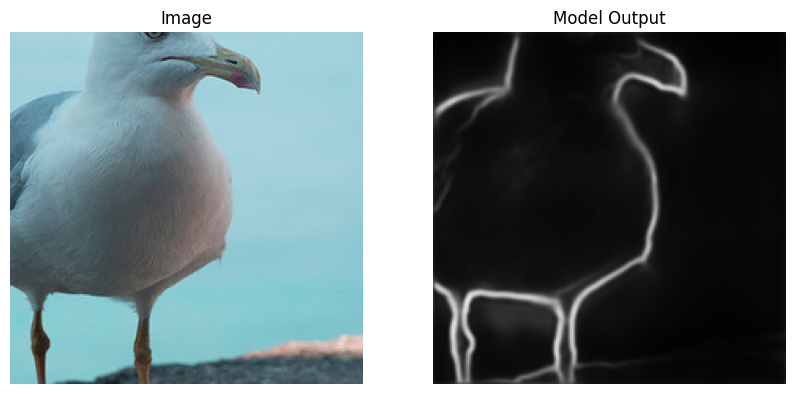

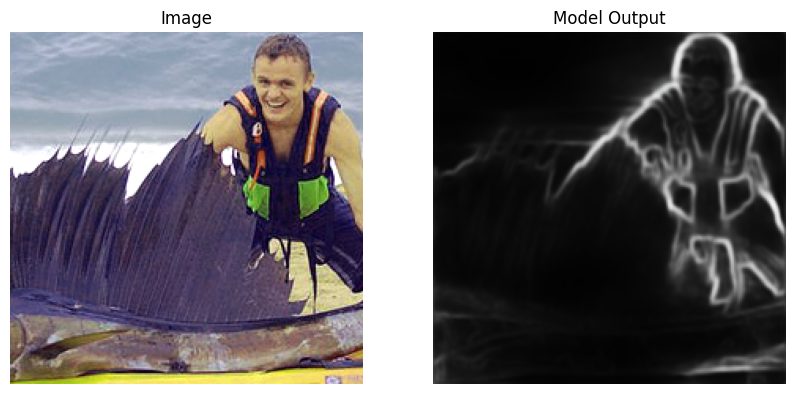

In [ ]:

model_path = dataroot+'best_GAN_model.pt'
model = torch.load(model_path)
generator = countour_detector(backbone=vgg16).to(device)
generator.load_state_dict(model)

def simple_predict(model):
    model.eval()

    dataset = GANDataset(dataroot, split='test', transform=train_transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

    with torch.no_grad():
        for batch_idx, (real_samples, labels) in enumerate(dataloader):
            if batch_idx >1:
                break
            else:
                real_samples = real_samples.to(device)
                output = model(real_samples)

                real_samples=real_samples.cpu().detach().numpy()[0]
                output = output.cpu().detach().numpy()[0]
                label = labels.cpu().detach().numpy()[0]
                
  
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
                ax1.axis("off")
                ax1.set_title("Image")
                ax1.imshow(real_samples.transpose((1, 2, 0)))

                ax2.axis("off")
                ax2.set_title("Model Output")
                ax2.imshow(output.transpose((1, 2, 0)))

                # print(g_loss)
                plt.show()

                
simple_predict(generator)

In [ ]:
my_model = countour_detector(backbone=vgg16).to(device)
my_model.load_state_dict(torch.load(dataroot+'best_GAN_model.pt'))

               

def avg_test_loss(model):
    model.eval()
    test_loss = 0
    num_samples = 0
    
    dataset = GANDataset(dataroot, split='test', transform=train_transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                             shuffle=True, num_workers=0)

    with torch.no_grad():
        for batch_idx, (real_samples, labels) in enumerate(dataloader):
            real_samples = real_samples.to(device)
            labels = labels.to(device)
            output = model(real_samples)
            batch_loss = context_loss(output, labels)
            test_loss += batch_loss.item()
            num_samples += 1

    avg_loss = test_loss / num_samples
    return avg_loss

avg_test_loss(my_model)

In [ ]:
import torchvision.transforms as T
from torchvision.utils import save_image

my_model = countour_detector(backbone=vgg16).to(device)
my_model.load_state_dict(torch.load(dataroot+'best_GAN_model.pt'))
my_model.eval()

# ----------------

img_folder = '/content/drive/MyDrive/585_data/celebA/img_align_celeba/'
final_folder = '/content/drive/MyDrive/585_data/final_contour/'


img_filenames = sorted(os.listdir(img_folder))

for i, img_filename in enumerate(img_filenames):
  if i >1:
    break
  else:
    img_path = os.path.join(img_folder, img_filename)
    
    img = Image.open(img_path)
    
    test_transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    
    img_tensor = test_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = my_model(img_tensor)
    
    output_img = T.ToPILImage()(output.squeeze(0).cpu())
    output_img.save(os.path.join(final_folder, f'output_{i}.png'))